In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, pytz
%matplotlib inline
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

## Predicting Amazon Revenues

The task is to predict Amazon.com, Inc.’s revenue for fiscal year 2017. The dataset given is available at

https://www.kaggle.com/dgawlik/nyse/data.

An additional dataset was also provided of the last 10 years of revenues, which is provided at the following link

https://www.statista.com/statistics/273963/quarterly-revenue-of-amazoncom/

Historically, studies have largely used autoregressive time series modelling to predict stock prices. More recently, studies exist where supervised machine learning models or deep learning models have been experimented with, by supplementing the traditional time series with derivations of the price, such as technical analysis indicators, or used more novel ways such as using natural language processing to analyse news headlines.

My aim in this study is to revisit and highlight the benefits and drawbacks of traditional time series modelling. In this case I will be demonstrating the benefits of using a seasonal ARIMA model to predict quarterly revenues.



## Data Cleaning and EDA
I created a CSV with the revenue data from statista, and imported into a dataframe. Upon checking the data, I noticed that there was a null value at the end of the series, and the dates associated with the series needs to form part of the index, so I clean this up below:

In [124]:
revenue = pd.read_csv('../../resource-datasets/nyse/amzn_revenue.csv')
revenue.head()

,date,revenue
0,01/03/2007,3.02
1,01/06/2007,2.89
2,01/09/2007,3.26
3,01/12/2007,5.67
4,01/03/2008,4.14


In [71]:
revenue.tail()

,date,revenue
39,01/12/2016,43.74
40,01/03/2017,35.71
41,01/06/2017,37.96
42,01/09/2017,43.74
43,NaN,NaN


In [127]:
#removing the null value at the end
revenue.drop(43, inplace=True,axis=0)

In [128]:
#Assigning the date column to the index, dropping index name
revenue['date'] = pd.to_datetime(revenue['date'], format="%d/%m/%Y")
revenue.set_index('date', inplace=True)
revenue.index.name = None

In [129]:
revenue.tail()

,revenue
2016-09-01,32.71
2016-12-01,43.74
2017-03-01,35.71
2017-06-01,37.96
2017-09-01,43.74


To make sure that our data is the same as shown on the website, I plot the series. It is evident that there is a seasonal peak towards the end of each year, and that the trend is generally upwards. In the case of a business like Amazon, this makes sense. predominantly, (with the exception of AWS) they are a consumer discretionary business, and typically makes a large percentage of their earnings around the Black Friday and Christmas periods. in addition, it would make sense that the1st quarter would experience a dip in revenues, as society tends to overspend during this period and reign in spending in January.

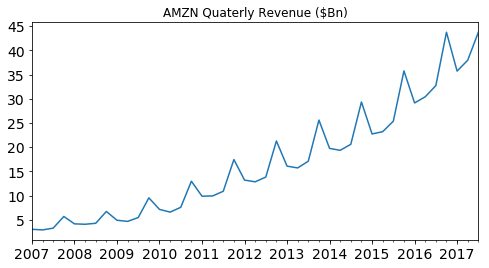

In [75]:
revenue.revenue.plot(figsize=(8,4), title= 'AMZN Quaterly Revenue ($Bn)', fontsize=14)
plt.show()

 A seasonal decomposition is a great way to visualise the series, as it shows the strength of the trend and seasonality on an individual basis, as well as a first glance at what the residuals could look like if you attempt to make the series stationary.

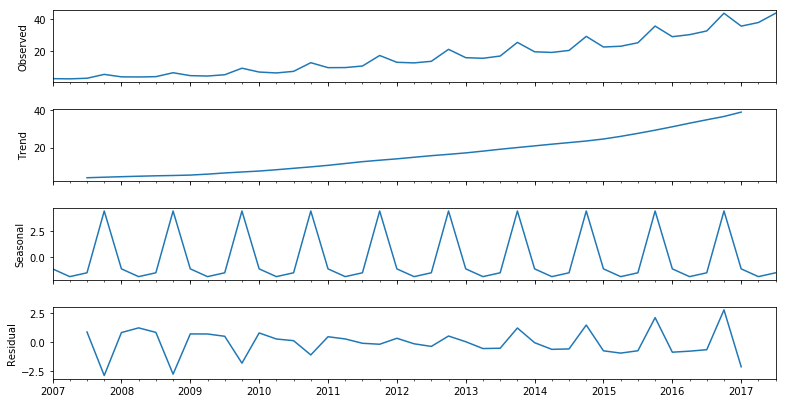

In [76]:
decomposition = seasonal_decompose(revenue.revenue)  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)
plt.show()

## Stationarity & Model Selection
In order to complete an effective time series analysis, one of the conditions that must hold is stationarity of the time series. We can test for this using the Augmented Dickey-Fuller test, and visually observe the mean of the time series. below are some helper functions which performs the ADF test, along with plotting the autocorrelation and partial autocorrelation.

In [145]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries,maxlag=None,regression='c',autolag='AIC'):
    '''Perform Dickey-Fuller test and print out results'''
    
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries,maxlag=maxlag,regression=regression,autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

def rolling(timeseries,window=4,center=False,figsize=(12,8)):
    '''Plot original timeseries, rolling mean over given window size and rolling 
    mean plus/minus standard deviation'''
    
    rolmean = timeseries.rolling(window=window, center=center).mean()
    rolstd = timeseries.rolling(window=window, center=center).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std_plus = plt.plot(rolmean+rolstd, color='red',ls='--', label = 'Rolling Mean +/- Rolling Std')
    std_minus = plt.plot(rolmean-rolstd, color='red',ls='--',label= '')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()  

def autocorrelation_plot(timeseries,lags=None):
    '''Plot autocorrelations and partial autocorrelations'''
    fig, ax = plt.subplots(ncols=2,figsize=(12,4))
    plot_acf(timeseries, lags=lags, ax=ax[0])
    plot_pacf(timeseries, lags=lags, ax=ax[1])
    plt.show()

def test_and_vis(timeseries):
    '''Perform Dickey-Fuller test, plot timeseries with rolling mean and autocorrelations'''
    test_stationarity(timeseries.dropna())
    rolling(timeseries)
    autocorrelation_plot(timeseries.dropna())

performing the test on the raw data performs as expected, as visually we know that the series is not stationary already. However, it is interesting to see that the series typically breaches 2 standard deviations to the topside, which may suggests that the growth rate in revenue is consistently strong.

Results of Dickey-Fuller Test:
Test Statistic                  2.237184
p-value                         0.998912
#Lags Used                      5.000000
Number of Observations Used    37.000000
Critical Value (5%)            -2.943539
Critical Value (1%)            -3.620918
Critical Value (10%)           -2.610400
dtype: float64


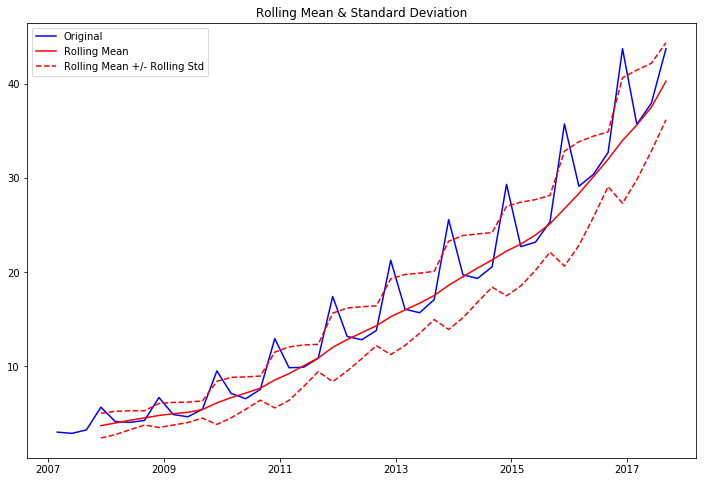

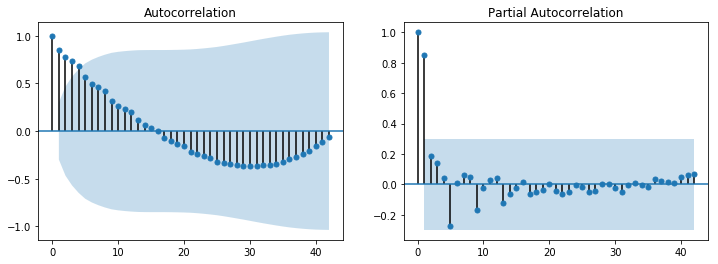

In [146]:
test_and_vis(revenue.revenue)

Taking the first difference of the series doesnt seem to make an impact on the stationarity, but it is noted that the standard deviation of the series is increasing over time.

Results of Dickey-Fuller Test:
Test Statistic                  1.944324
p-value                         0.998596
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (5%)            -2.948510
Critical Value (1%)            -3.632743
Critical Value (10%)           -2.613017
dtype: float64


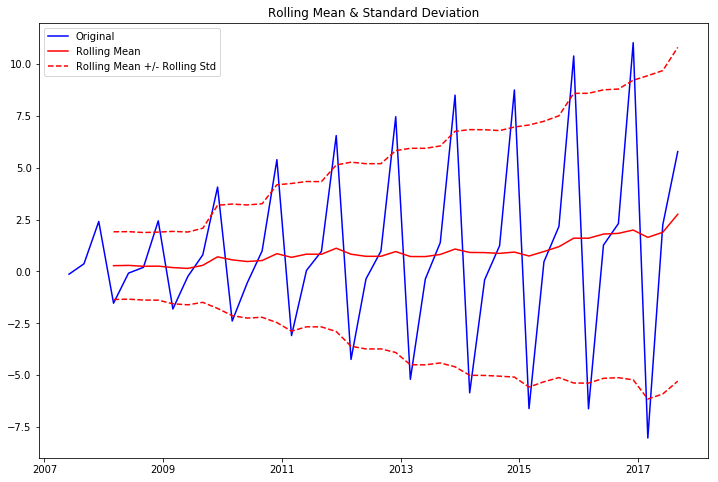

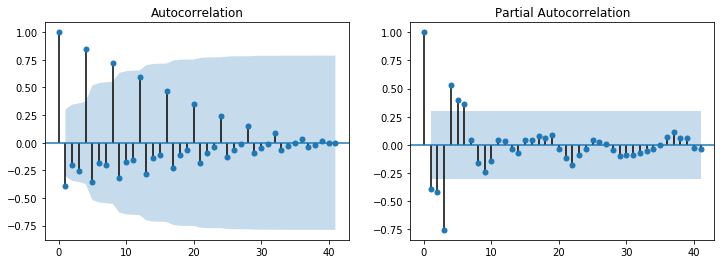

In [132]:
# first difference
revenue['first_difference'] = revenue.revenue.diff()

test_and_vis(revenue.first_difference)

Taking the second difference of the series seems to improve the t-stat and p-value results but still does not reach the critical values for significance.

Results of Dickey-Fuller Test:
Test Statistic                 -0.819966
p-value                         0.813187
#Lags Used                      8.000000
Number of Observations Used    32.000000
Critical Value (5%)            -2.957219
Critical Value (1%)            -3.653520
Critical Value (10%)           -2.617588
dtype: float64


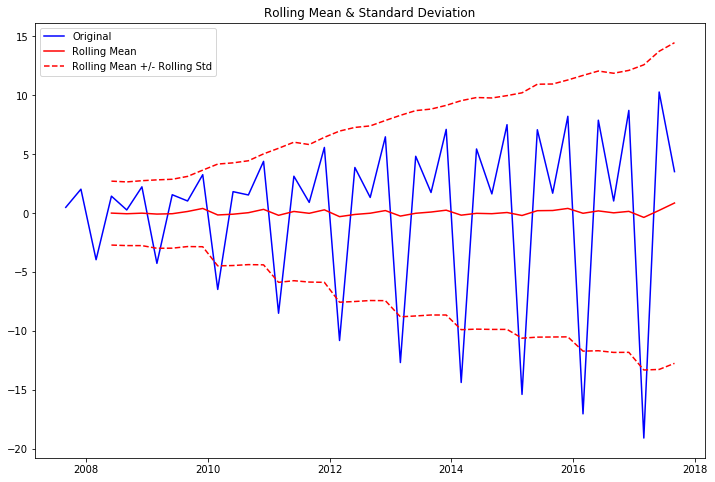

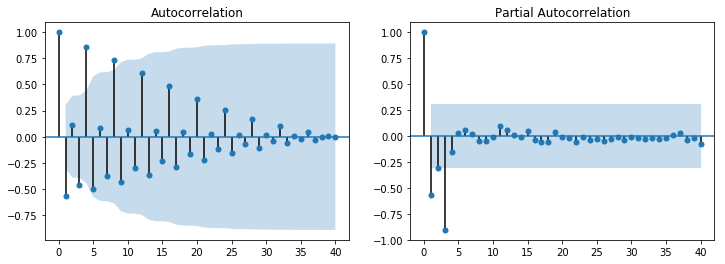

In [133]:
# second difference
revenue['second_difference'] = revenue.revenue.diff().diff()

test_and_vis(revenue.second_difference)

On the third difference, the series becomes stationary. The t-stat is significant at the 1% level, and the p-value is less than 0.05, and also significant. Although the standard deviation looks expansionary, the rolling mean remains stable around 0.

Results of Dickey-Fuller Test:
Test Statistic                 -3.852558
p-value                         0.002413
#Lags Used                      7.000000
Number of Observations Used    32.000000
Critical Value (5%)            -2.957219
Critical Value (1%)            -3.653520
Critical Value (10%)           -2.617588
dtype: float64


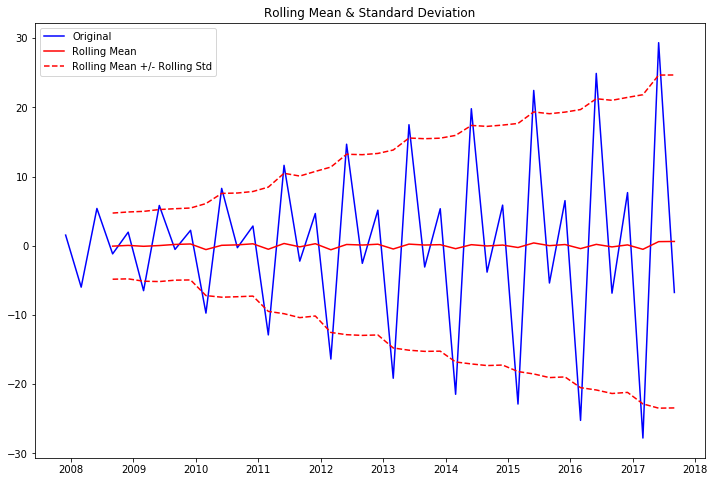

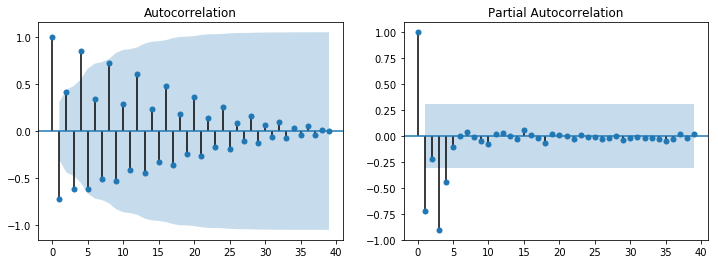

In [134]:
# third difference
revenue['third_difference'] = revenue.revenue.diff().diff().diff()

test_and_vis(revenue.third_difference)

Turning to the seasonality, we can see that the series becomes stationary at the second difference. For completeness, I perform the ADF test on three differences, and plot the respective graphs.

Results of Dickey-Fuller Test:
Test Statistic                  0.722888
p-value                         0.990284
#Lags Used                      7.000000
Number of Observations Used    30.000000
Critical Value (5%)            -2.964071
Critical Value (1%)            -3.669920
Critical Value (10%)           -2.621171
dtype: float64


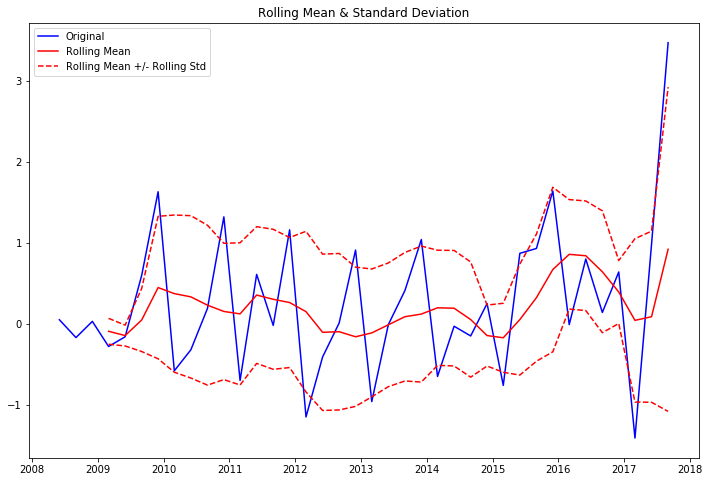

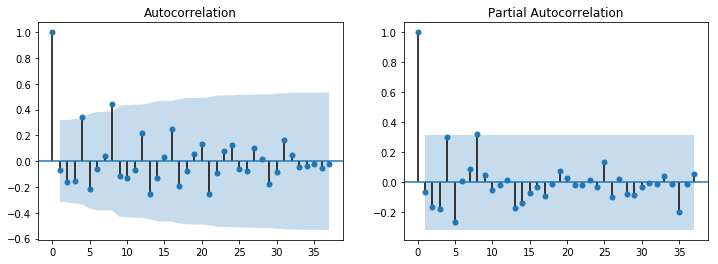

In [135]:
# first seasonal difference
revenue['seasonal_first_difference'] = (revenue.revenue - revenue.revenue.shift(4)).diff()

test_and_vis(revenue.seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                 -4.007464
p-value                         0.001372
#Lags Used                      6.000000
Number of Observations Used    30.000000
Critical Value (5%)            -2.964071
Critical Value (1%)            -3.669920
Critical Value (10%)           -2.621171
dtype: float64


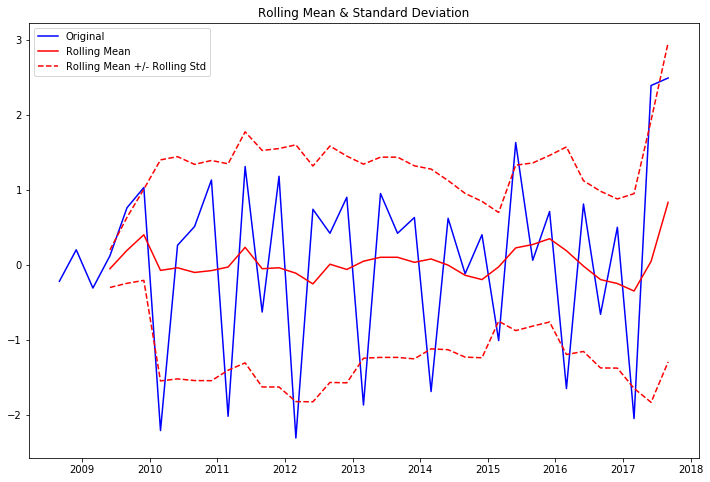

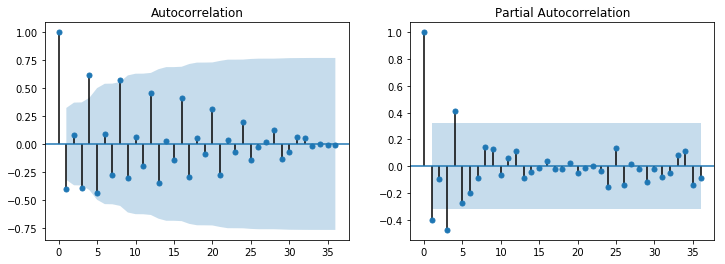

In [136]:
revenue['seasonal_second_difference'] = (revenue.revenue - revenue.revenue.shift(4)).diff().diff()

test_and_vis(revenue.seasonal_second_difference)

Results of Dickey-Fuller Test:
Test Statistic                 -3.609571
p-value                         0.005581
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


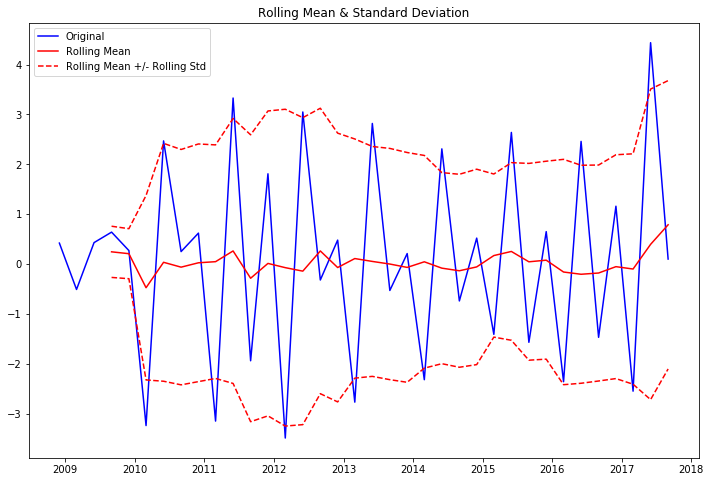

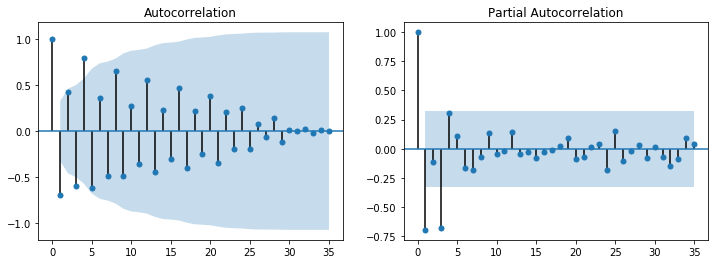

In [137]:
revenue['seasonal_third_difference'] = (revenue.revenue - revenue.revenue.shift(4)).diff().diff().diff()

test_and_vis(revenue.seasonal_third_difference)

To summarise, we select the model that incurs the lowest p-value. In this case, this occurs at the third difference for the non seasonal component, and at the second difference for the seasonal component. I then try various moving averages that minimises the AIC criterion, and the final model is displayed below.

In [138]:
for col in revenue.columns:
    print 'p-value', col
    print '\t\t', adfuller(revenue[col].dropna())[1]

p-value revenue
		0.998911731997
p-value first_difference
		0.998596086548
p-value second_difference
		0.813186876057
p-value third_difference
		0.00241310746976
p-value seasonal_first_difference
		0.990283740244
p-value seasonal_second_difference
		0.00137192602426
p-value seasonal_third_difference
		0.00558066765793


In [156]:
data = revenue.revenue
model = sm.tsa.statespace.SARIMAX(data, order=(0,3,1), seasonal_order=(1,2,1,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                           revenue   No. Observations:                   43
Model:             SARIMAX(0, 3, 1)x(1, 2, 1, 4)   Log Likelihood                 -40.175
Date:                           Mon, 22 Jan 2018   AIC                             88.350
Time:                                   16:30:19   BIC                             95.395
Sample:                               03-01-2007   HQIC                            90.948
                                    - 09-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9543      0.631     -1.512      0.130      -2.191       0.283
ar.S.L4       -0.1914      0.382     -0.501      0.616      -0.940       0.557
ma.S.L4       -0.7076      0.411     -1.721      0.085      -1.513       0.098
sigma2         0.5593      0.341      1.641      0.101      -0.109       1.227
===================================================================================
Ljung-Box (Q):                       50.22   Jarque-Bera (JB):                 7.12
Prob(Q):                              0.02   Prob(JB):                         0.03
Heteroskedasticity (H):               1.48   Skew:                             0.64
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looking at the results of the model, the residuals remain relatively stable, and largely follows a normal distribution. The quantile plot of theoretical vs sample observations shows that the model is a reasonably good fit.

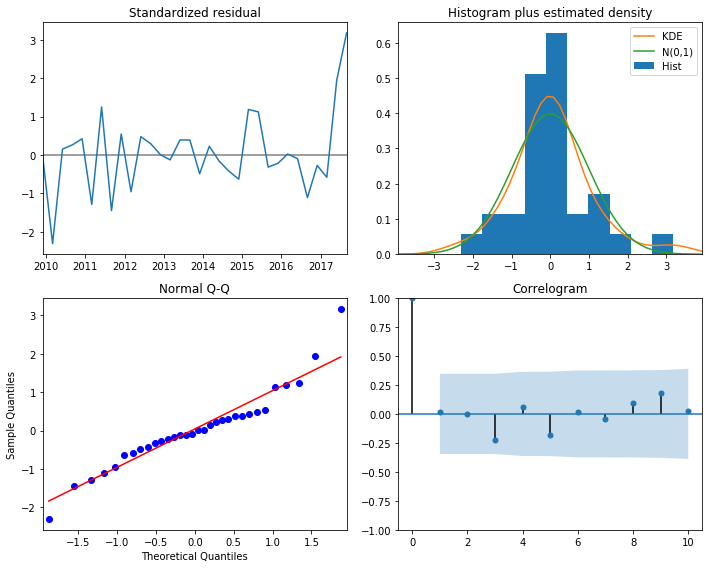

In [140]:
results.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

Putting the model to the test, I build a forecast out to two periods. The blue dots represents the actual observations, and the dotted line represents the forecast. By extracting these predictions, we can see that we have estimated revenue for the 4th quarter to be 59.14bn USD.

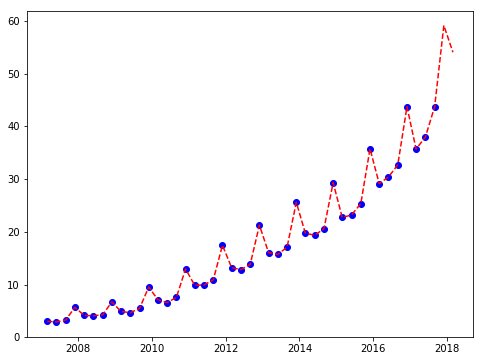

In [141]:
# forecasting
preds = results.forecast(2)
fcast = pd.concat([data,preds])

plt.figure(figsize=(8,6));
plt.plot(data, 'bo' , fcast, 'r--');

In [142]:
preds

2017-12-01    59.149130
2018-03-01    54.070608
Freq: QS-DEC, dtype: float64

Visually, this looked like an acceptable figure, but I wanted to check with the actual analysts estimates, to see if this was a reasonable figure. When compared to official revenue estimates, the average is 59.8bln USD, which shows that our model looks to be in line with consensus.                   
(source: https://finance.yahoo.com/quote/amzn/analysts?ltr=1)

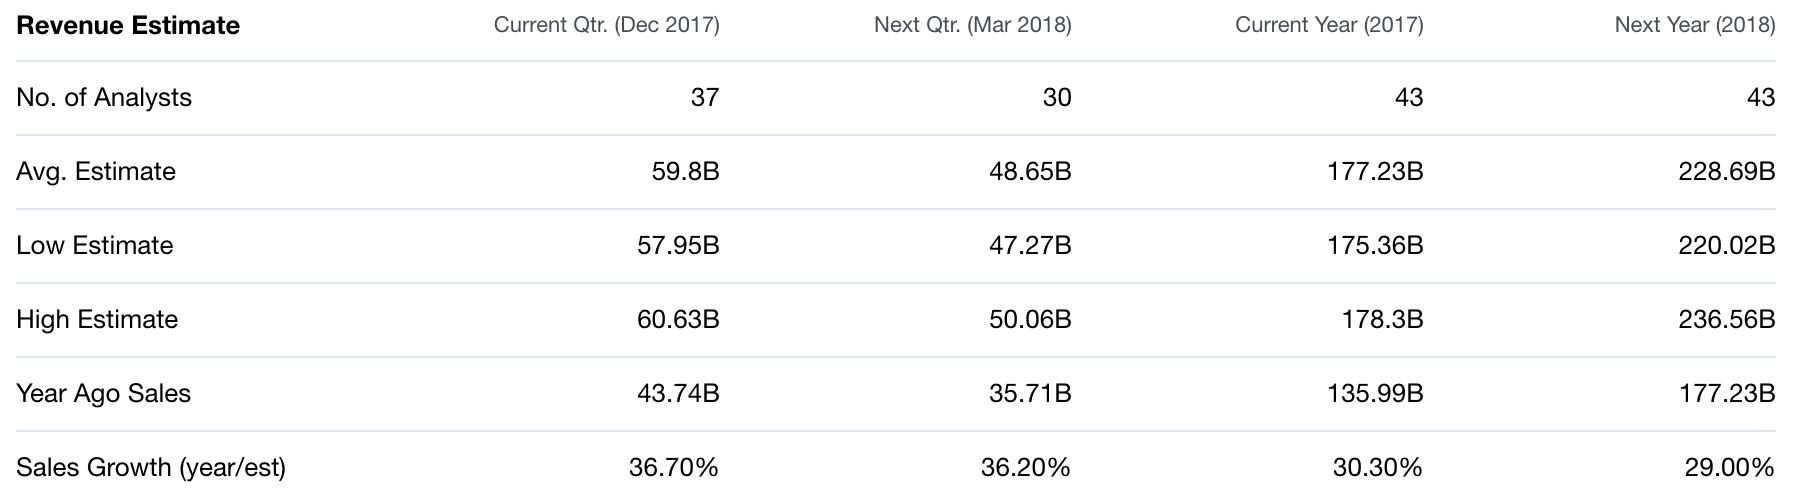

### Conclusion

I have demonstrated that whilst fundamental analysts may spend considerable time constructing fundamental bottom up models, through seasonal decompostition and autocorrelation it is possible to produce equally good revenue estimates.

### What are the drawbacks?

Because the analysis is largely focused on endogenous timeseries (as we control for trends and seasonality) we also are ignoring exogoneous data that can make an impact to this work. For example, during this period, Amazon made a purchase of Whole Foods, which was valued at $13.7B and the deal was in cash:

<img src="https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F369200e9ef764f8fb850543a6882f53c%2F960x0.jpg%3Ffit%3Dscale">

Whole Foods reported full-year revenue of $16.03 billion in 2017, compared with revenue of $15.72 billion for fiscal 2016, which is completely unaccounted for in this study. As a result, given that the analysis estimates are in line with our "narrow view" analysis, this would provide a great opportunity to trade on the surprise to the analysts estimates based on this kind of data.

Amazon revenues came in at $60.5 billion at the fourth quarter 2017, accounting for the additional whole foods revenues, and the stock rose 7% as a result of this surprise.

### Further work
This work could be extended. One of the challenges is that readily available stock prices and data such as revenues are of differing series. Stocks typically are daily observations, where revenues or Earnings per share are published quarterly. The initial instinct would be to resample the stock prices to quarterly observations to match the revenue estimates, and analyse the returns between the quarters. You could also look at returns 1 week prior, 2 weeks prior and 1 month prior to announcements to see if these have any predictive power. The downside in approaching it this way, is that the number of observations to train a model is severely constrained. In our model above, with 10 years of data, we only have 40 observations.

Another way could be to interpolate the earnings to effectively generate more observations to train a model. In this case, you could create monthly estimated observations of revenue, and resample the daily stock prices to monthly to smooth the series. You can also create features such as technical analysis indicators, or take logs of the prices to measure returns rather than absolute values, as recent literature suggests that this is a common route to take.